In [1]:

import numpy as np
import blip_analysis as ba
import matplotlib.pyplot as plt
import pickle
import scipy
from tqdm import trange
from matplotlib.gridspec import GridSpec
from label_axes import label_axes
from scipy.optimize import minimize

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

b


In [2]:
## Load data
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()
glyphs = ba.get_glyphs()

Found odour 1
Found odour 3
Found odour 5


In [3]:
### Run to load in all the models
diff_models1 = pickle.Unpickler(open('../Data/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('../Data/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('../Data/230320_diff_models3.pkl', 'rb')).load()
model_length = 130

In [4]:
### Loading responsive cells from the 230509_fig5_2PCs.ipynb - only cells which are 'responsive' to all three odours
responsive_only_cells = np.load('../Data/230515_all_responsive_cells.npy')
diff_models1 = diff_models1[responsive_only_cells]
diff_models2 = diff_models2[responsive_only_cells]
diff_models3 = diff_models3[responsive_only_cells]
model_length = 66

In [5]:
### Fit all models to ensure their weighting has all repeats
[i.fit() for i in diff_models1];
[i.fit() for i in diff_models2];
[i.fit() for i in diff_models3];

In [6]:
## calculate the mean and std of each cell
mean_usrt1 = [[np.mean(np.mean(i, axis=-1)) for i in j] for j in unit_usrt1[good_indexes][responsive_only_cells]]
std_usrt1 = [[np.std(np.mean(i, axis=-1)) for i in j] for j in unit_usrt1[good_indexes][responsive_only_cells]]
mean_usrt2 = [[np.mean(np.mean(i, axis=-1)) for i in j] for j in unit_usrt2[good_indexes][responsive_only_cells]]
std_usrt2 = [[np.std(np.mean(i, axis=-1)) for i in j] for j in unit_usrt2[good_indexes][responsive_only_cells]]
mean_usrt3 = [[np.mean(np.mean(i, axis=-1)) for i in j] for j in unit_usrt3[good_indexes][responsive_only_cells]]
std_usrt3 = [[np.std(np.mean(i, axis=-1)) for i in j] for j in unit_usrt3[good_indexes][responsive_only_cells]]
corrs = [np.corrcoef(i, j)[0, 1] for i, j in zip(mean_usrt1, mean_usrt2)]
print(np.argsort(np.abs(corrs)))
corr_args = np.argsort(np.abs(corrs))

[ 3 51 41 12  4 24  2 63 31 52 49 53 21 44  6 47 22 25 64 10 43 36 16 13
 11 58 15 60 56 23 20  5 55 54 17 62 48  8 59  0 50  1 57 18 45  9 33 26
 14 35 30 46 29 28 42 38 19 65 61 27  7 40 37 32 39 34]


In [7]:
### Load in the other odour fit results (this takes the 66 responsive cells)
res = np.load('../Data/230704_other_odour_fits.npy', allow_pickle=True)

In [8]:
## reshaping
cell_preds12 = res[0, 0, :, 0, :]
scores12 = res[0, 0, :, 1, :]
cell_preds13 = res[0, 1, :, 0, :]
scores13 = res[0, 1, :, 1, :]
cell_preds21 = res[1, 0, :, 0, :]
scores21 = res[1, 0, :, 1, :]
cell_preds23 = res[1, 1, :, 0, :]
scores23 = res[1, 1, :, 1, :]
cell_preds31 = res[2, 0, :, 0, :]
scores31 = res[2, 0, :, 1, :]
cell_preds32 = res[2, 1, :, 0, :]
scores32 = res[2, 1, :, 1, :]

In [16]:

def plot_multi_odour_response2(cell_index, odour1, odour2, ax=None, odour1_std = None, odour2_std = None, legend=False, remove_spine_top=False, fs=10):
    '''Plots the responses of a given cell to two odours, scaled to minimise the sum of squared differences'''
    data1 = np.array(odour1[cell_index])
    data2 = np.array(odour2[cell_index])
    lower, upper = auto_scale(odour1, odour2, cell_index)
    scaled_data2 = lower + (data2 - np.min(data2))*(upper - lower) / (np.max(data2) - np.min(data2))
    scaled_err = np.abs((upper - lower) / (np.max(data2) - np.min(data2)) * np.array(odour2_std[cell_index]))

    print(min(scaled_err), max(scaled_err))
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.errorbar(np.arange(0, 64, 2), data1, yerr=odour1_std[cell_index], fmt='.', color='k', linewidth=1)
    ax.errorbar(np.arange(0.5, 64.5, 2), scaled_data2, yerr=scaled_err,  fmt='.', color='r', linewidth=1)
    ax.set_xticks(np.arange(0.25, 64.25, 2))
    ax.set_xticklabels(glyphs, rotation=90, fontsize=fs);
    ylims = ax.get_ylim()
    ax2 = ax.twinx()
    scaled_ylims = ((np.array(ylims) - lower) * (np.max(data2) - np.min(data2)) / (upper - lower)) + np.min(data2)
    ax2.set_ylim(scaled_ylims)
    ax2.set_ylabel('Firing rate O2 (Hz)', color='r')
    ax2.tick_params(axis='y', colors='red')
    ax2.spines['right'].set_color('red')
    ax.set_ylabel('Firing rate O1 (Hz)')
    if remove_spine_top:
        ax.spines['top'].set_visible(False)
        ax2.spines['top'].set_visible(False)

def auto_scale(odour1, odour2, ui):
    '''Automatically scales the two odour responses to minimise the sum of squared differences'''
    data1 = np.array(odour1[ui])
    data2 = np.array(odour2[ui])

    x_data = np.array(range(32))
    init_limits = [0, 100]

    result = minimize(calc_diff, init_limits, args=(data1, data2), method='Nelder-Mead', tol=1e-20, options={'maxiter': 10000})
    return result.x

def calc_diff(limits, data1, data2):
    '''Calculates the sum of squared differences between two odour responses, scaled to the limits given'''
    lower, upper = limits
    
    # Rescale data
    scaled_data2 = lower + (data2 - np.min(data2))*(upper - lower) / (np.max(data2) - np.min(data2))
    
    # Calculate sum of squared differences
    diff = np.sum((data1 - scaled_data2)**2)
    return diff


1.2985089072817302 3.8843649675395393
1.070132051517697 3.6529751411008284
4.3164890809871705 13.911223352319738
1.6540145377072215 11.341039401630681


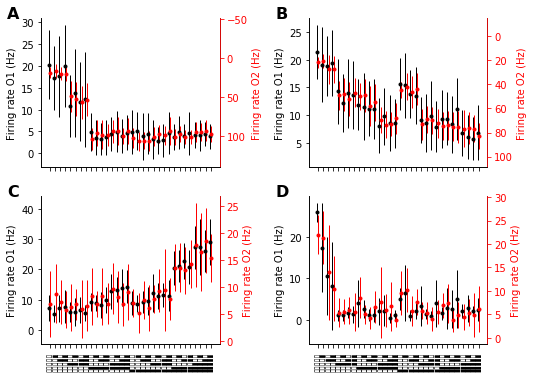

In [24]:
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 2, wspace=0.5)
response_ax1 = fig.add_subplot(gs[0, 0])
response_ax2 = fig.add_subplot(gs[0, 1])
response_ax3 = fig.add_subplot(gs[1, 0])
response_ax4 = fig.add_subplot(gs[1, 1])
fs=7
plot_multi_odour_response2(corr_args[-2], mean_usrt1, mean_usrt2, odour1_std=std_usrt1, odour2_std=std_usrt2, ax=response_ax1, remove_spine_top=True)
plot_multi_odour_response2(corr_args[-6], mean_usrt1, mean_usrt2, odour1_std=std_usrt1, odour2_std=std_usrt2, ax=response_ax2, remove_spine_top=True)
plot_multi_odour_response2(corr_args[-10], mean_usrt1, mean_usrt2, odour1_std=std_usrt1, odour2_std=std_usrt2, ax=response_ax3, remove_spine_top=True, fs=fs)
plot_multi_odour_response2(corr_args[-9], mean_usrt1, mean_usrt2, odour1_std=std_usrt1, odour2_std=std_usrt2, ax=response_ax4, remove_spine_top=True, fs=fs)
response_ax1.set_xticklabels([])
response_ax2.set_xticklabels([])
axes = [response_ax1, response_ax2, response_ax3, response_ax4]
labels = ['A', 'B', 'C', 'D']
align_x = [[0, 2], [1, 3]]
align_y = [[0, 1], [2, 3]]
label_axes.label_axes(axes, labels, align_x=align_x, align_y=align_y, fontsize=16, fontweight='bold')
plt.savefig('230912_Sup71.pdf', bbox_inches='tight')